In [1]:
#imports 
import mne
import numpy as np
import pandas as pd
import os
import glob
from matplotlib import pyplot as plt
import sys
import warnings

import seaborn as sns
from itertools import product as prod

In [2]:
import time

In [33]:
class eeg_dynamic_read:
    
    '''class reads in eeg data and finds the appropriate read in method from mne.io
    
    file : (String) - Name of eeg data file to read in
    montage : (Sting) - name of montage file associated with the eeg file
    
    '''
    def __init__(self, file, montageFile):
        self.file=file
        self.montage=montageFile
    
    def read_eeg(self):
        eeg_type='read_'+self.file.split('.')[-1]
        method=getattr(self, eeg_type, lambda: 'Invalid Type')
        return method()
    
    def read_sqd(self):
        return mne.io.read_raw_kit(self.file,self.montage)
    
    def read_vhdr(self):
        return mne.io.read_raw_brainvision(self.file,self.montage)

    def read_ctf(self):
        return mne.io.read_raw_ctf(self.file,self.montage)
    
    def read_edf(self):
        return mne.io.read_raw_edf(self.file,self.montage)

    def read_bdf(self):
        return mne.io.read_raw_edf(self.file,self.montage)
    
    def read_gdf(self):
        return mne.io.read_raw_ctf(self.file,self.montage)

    def read_egi(self):
        return mne.io.read_raw_egi(self.file,self.montage)
    
    def read_mff(self):
        return mne.io.read_raw_egi(self.file,self.montage)
    
    def read_set(self):
        return mne.io.read_raw_eeglab(self.file,self.montage)

    def read_nxe(self):
        return mne.io.read_raw_eximia(self.file,self.montage)
    
    def read_cnt(self):
        return mne.io.read_raw_cnt(self.file, self.montage)
    
class subject:
    def __init__(self, ID, data, montage, eventIDs=None):
        """
        Subject class the contain individual subject data and the methods necessary to 
        do all within subjects processing and analyses
        
        ID: (String/Int) - Subject Identifier
        data : (String) - name of data file - automatically loaded into mne with dynamic read
        montage : (String) - name of monatage file automatically loaded into mne with dynamic read
        eventIDs : (Dict) - mapping of event names to event codes
        
        """
        self.ID=ID
        self.data=eeg_dynamic_read(data, montage).read_eeg()
        self.events=mne.find_events(self.data)
        self.event_ID=eventIDs if eventIDs else list(np.unique(self.events[:,2]))
        self.sample_rate=self.data.info['sfreq']
        
        #data stores for sample data
        #electorde x event code x event x time
        self.sample_channels=None
        self.sample_store=None
        self.sample_events=None
        
        #bootstrap dependedant struture
        # boot shape x random Draws
        self.boot_store=None
    
    def get_item_eeg(self, tmin=-.1, tmax=.8, baseline=(None,0.0), 
                         events=None, chans=[],  average=False, store=False):
        
        """function epochs the data and returns an electrode x event code x event x sample array, with option
        to store in the sample_store attribute.
          
        tmin : (float/int) - time in seconds to begin epoch
        tmax : (float/int) - time in seconds to end epoch
        baseline : (tuple of ints) - beginning, end of baseline period
        events : (list of strings or Ints) list of events names to pull out
        chans : (list of strings) - list of channel names to get data from
        average : (boolean) : whether or not to average the data
        store : (boolean) : whether or not to store data in the class attribute
        
        """
        
        if not events:
            raise 'Event of Interest Must be specified'
        if not chans:
            chans=[self.data.info['ch_names'][k] for k in mne.pick_types(self.data.info, eeg=True)]
        
        erp=mne.Epochs(self.data, events=self.events, event_id=self.event_ID, tmin=tmin,
                       picks=mne.pick_channels(self.data.info['ch_names'], chans),
                    tmax=tmax, baseline=baseline, preload=True)
        
        #swap axes 0,1
        if average:
            ret=erp[event].average(picks=chans)
        else:
            ret=np.array([erp[event].get_data() for event in events])
            
            #strutuces the array
            ret=np.swapaxes(np.swapaxes(ret, 0, 2), 1, 2)
        
        #option to store the data as part of the class
        #or return in
        if store:
            self.sample_channels=chans
            self.sample_store=ret
        else:   
            return ret
    
        
    def random_draw(self, array, nDraws=100, sampleSize=None, replacement=True):
        '''
        returns an array of boot-strapped means along the last axis of the passed array
        
        array : (nD array)
        nDraws : (int) - number of means to generate
        sampleSize : (int) - number of sample to take on each draw
        replacment : (boolean) - replacement for draws
        '''
        
        if sampleSize:
            warnings.warn("Sampling at adjusted sample size is not recommended for boot-strapping")
        if not replacement:
            warnings.warn("Sampling at without replacement is not recommended for boot-strapping")
        
        #pull size of the array's last dimension as deflault sample size
        samplesSize = sampleSize if sampleSize else array.shape[-1] 
        
        def _make_index(shape):
            '''takes in array shape tuple and out puts a list of all 
            index combinations'''
            ind=list(map(range, shape))
            ind=list(map(list, ind))
            return list(prod(*ind))
        
        #get the necessary array shape for initiating the matrix
        arrShape=list(array.shape)[:-1]
        arrShape.extend([nDraws])
        
        #intiate thats shape x random draw
        boot_dist=np.zeros(arrShape)
        
        for idx in _make_index(arrShape):
            #pull out random indexes and slice the array
            rand_idx=np.random.choice(array.shape[-1], size=sampleSize, replace=replacement)
            
            #we have to pull out all but the last element of the idx tuple so that we're drawing
            #from the correct groups
            pulled_data=array[idx[:-1]]
            boot_dist[idx]=np.mean(pulled_data[rand_idx])
        
        return boot_dist
        
    
    def get_mean_amp(self, flatten_axes=None, boots=200, samples=None):
        
        '''get the mean amplitude accross the epoch'''
        mean_amp=np.mean(self.sample_store, (len(self.sample_store.shape)-1))
        
        if flatten_axes:
            mean_amp=mean_amp.reshape(*mean_amp.shape[:flatten_axes], -1)
        self.boot_store= self.random_draw(mean_amp,nDraws=boots, sampleSize=samples)
     
        
    
    def peak_latency(self):
        pass
    
    def get_summary_stats(self, stats=['std']):
        '''returns array of summary statistics along the last axis and axis mappings
        
        stats : (list of strings) - names of numpy stats functions to be called on the data
        
        '''
        if len(stats)==1:
            return getattr(np, stats[0])(self.boot_store, -1)
        else:
            return np.array([getattr(np, k)(self.boot_store, -1) for k in stats])
         
        
class boots: 
    def __init__(self, fileDir=None,  dataType=None, montage=None, eventMap=None):
        
        '''class that serves as the group level data type
        
        fileDir : (String) - file path (organized to BIDs specs)
        dataType : (String) - type of eeg file being loaded in
        montage : (Stinge) - path for montage file
        eventMap : (Dict) - dictionary with Key, Value pairs that specify event name, event code
        
        '''
        if not dataType:
            raise 'EEG file type must be specified'
       
        #search the whole directory tree for anything with the 
        #specified data type
        self.directory=fileDir
        self.files=glob.glob(os.path.join(fileDir, '**', 'EEG', ('*' + dataType)))                            
        self.montage=montage
        self.data=None
        self.eventMap=eventMap
        
        #store for boot strapped SE's
        #subject x shape 
        self.boot_SE=None
        
        #stores for outputs
        self.mean_error=None
        self.mean_stdError=None
        
        self.subsets={}
        
        
    def get_name(self, fstring):
        '''gets subject ID from file string'''
        return fstring.split(os.sep)[-3]
        
    def load_data(self):
        '''load method after intial init, this will give us the flexibility to restart after node subsetting if we need to'''
        dats=[subject(ID=self.get_name(file),data=file, montage=self.montage, eventIDs=self.eventMap) for file in self.files]
        
        #default group level event mappings
        #to the subject level defualt
        if not self.eventMap:
            warnings.warn('No event mappings specified... Using event codes as names')
            self.eventMap=dats[0].event_ID
        
        self.data=dats
    
    
    def epoch_subjects(self,tmin=-.2, tmax=.8, baseline=(None,0.0), 
                         event=None, chans=[], average=False, store=False):
       
        if not chans:
            chans=[self.data[0].data.info['ch_names'][k] for k in mne.pick_types(self.data[0].data.info, eeg=True)]
        
        #sets what we pulled out for the analyses so we can 
        self.subsets['electrode']=chans
        self.subsets['eventName']=event
        
        #creates the epoch data for each subject
        [s.get_item_eeg(tmin=tmin, tmax=tmax, baseline=baseline,events=event, chans=chans, average=average, store=store) for s in self.data]
        
        
    def mean_amplitude(self, flatten_axes=None, boots=200, samples=None, return_stats=['std']):
        
        if flatten_axes >2:
            warnings.warn('Axis conservation may result in longer processing times')
        #boot each subject in turn
        [s.get_mean_amp(flatten_axes=flatten_axes, boots=boots, samples=samples) for s in self.data]
        
        
        if return_stats:
            #save standard error measures for each subject into the class
            self.boot_SE=np.array([s.get_summary_stats(stats=return_stats) for s in self.data])
            
            #output data quality measurements
            self.mean_error=np.mean(self.boot_SE, 0)
            self.mean_stdError=np.std(self.boot_SE, 0)
    
    
    def plot_boots(self, data='boot_store', data_key='electrode', col_wrap=5, figureSize=(20, 20), cols='Spring',
                  title=None, save=False):
        
        #sub optimal implimentation
        key2axes={'subject':0, 'electrode':1, 'eventName':2, 'event':3, 'time':4}
        
        try:
            #turn to 2d array along the desired axis
            plot=getattr(self, data).reshape(getattr(self, data).shape[key2axes[data_key]], -1)
            
            
            #transpse the array for plotting
            plot=(plot.T) *1e6
                
            print (plot.shape)
            
            plt.figure(figsize=figureSize)
            plter=sns.stripplot(data=plot, palette=cols, jitter=True)
            plter.set(xticklabels=self.subsets[data_key], xlabel=data_key, ylabel='MicroVolts')
            plt.title(title)
          
        except:
            raise 
        
        if save:
            if not os.path.exists(os.path.join(self.directory, 'Figures')):
                os.mkdir((os.path.join(self.directory, 'Figures')))
            
            plt.savefig((os.path.join(self.directory, 'Figures', data_key + '.png')))
                      
                        
        
       

In [34]:
direct='C:/Users/Phil/Box Sync/Classes/PSC_290_Final/data'
mont=os.path.join(direct, 'BP64_acti_64rows.sfp')

#event mappings for the test data
evMaps={'1': 1, '2': 2, '3': 3, '48': 48, '77': 77, '88':88, '100': 100, '200' : 200}

The graph shows test output for channel Fz at event code 2. Data are baselined in the interval -200ms - 0ms prior to stimulus onset. max time is 800ms

In [35]:
%%capture


start1 = time.time()
dats=boots(fileDir=direct, dataType='cnt', montage=None, eventMap=None)
dats.load_data()

dats.epoch_subjects(tmin=-.2, tmax=.8, baseline=(None,0.0), 
                    event=['1', '2', '3'], chans=None, store=True)

end1 = time.time()

start = time.time()
dats.mean_amplitude(flatten_axes=1, boots=1000)
end = time.time()

In [36]:
dats.boot_SE.shape

(9, 64)

(9, 64)


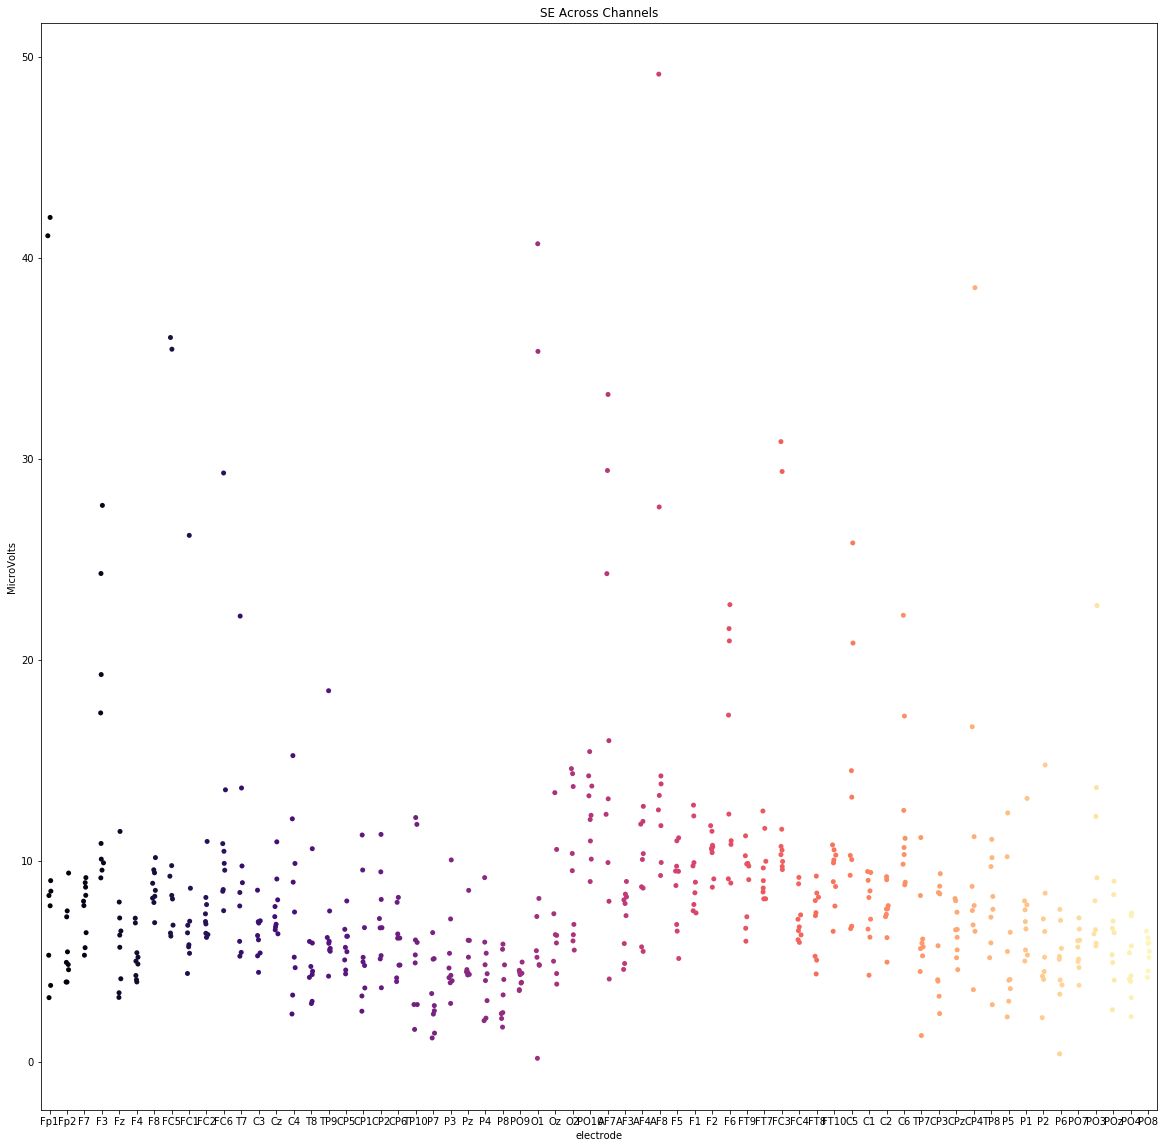

In [38]:
dats.plot_boots(data='boot_SE', data_key='electrode', figureSize=(20, 20), cols='magma',
                  title='SE Across Channels', save=False)


In [93]:
end-start

9.929118394851685

In [94]:
dats.boot_SE.shape

(9, 64)

In [59]:
dats.boot_SE.shape

(9, 6)